# Computational Complexities and Scalability Tests for Parallel Iterative Archetypal Analysis

This notebook contains analysis plots for the (time) complexity analysis and scaling tests (strong scaling speedup and weak scaling parallelisation efficiency) of the parallel iterative archetypal analysis algorithm.

## General settings

### Notebook setups

Settings for the notebook.

In [12]:
from math import ceil, log10
from os import chdir, getcwd, listdir

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from natsort import natsorted
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler

# chdir('/scratch/q27/jt5911/iterative-archetypal-analysis/archive/complexityScaling')
chdir('/scratch/q27/jt5911/iterative-archetypal-analysis/iaa/docs')
import iaa
# from iaa.piaa import ArchetypalAnalysis, subsetSplit, submitAAjobs, runAA, fitPIAA

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  iaa: {iaa.__version__}")
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  iaa: 0.1.0
  matplotlib: 3.9.1
  numpy: 1.26.4
  pandas: 2.2.2
  seaborn: 0.13.2
  scikit-learn: 1.5.1


Below are some general settings for plotting figures:

In [13]:
sns.set_context('paper')  # Options are: {paper, notebook, talk, poster}
sns.set_palette('Paired')
plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
figSize, dpi, fontSize, labelSize = (3.5, 2.5), 300, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
hexCodes = ['#E11845', '#0057E9', '#FF00BD', '#8931EF']

And some specific settings for box plots:

In [14]:
flierprops = dict(marker='x', markerfacecolor='r', markersize=3, markeredgecolor='k', linestyle='none')
boxprops = dict(linestyle='-', linewidth=0.8, edgecolor='k')
whiskerprops = dict(linestyle='-', linewidth=0.5, color='k')
capprops = dict(linestyle='-', linewidth=1.2, color='k')
medianprops = dict(linestyle='--', linewidth=1.2, color='r')
meanprops = dict(marker='s', markerfacecolor='w', markersize=3, markeredgecolor='b', linestyle='none')

In [15]:
# General variables
RANDOM_STATE = 42
NUM_DIM_MANIFOLD = 2
VERBOSE = True
NUM_JOBS = 48

# Variables specific for splitting data into subsets
SHUFFLE = True  # Whether to shuffle data samples before splitting.

# Variables specific for archetypes.py functionalities
C = 0.0001  # constraint coefficient to ensure that the summation of alpha and beta equals to 1.

# Variables specific for the archetypal analysis algorithm provided by the SPArse Modeling Software (SPAMS) package
ROBUST = False  # Whether to use modified AA algorithm to deal with outliers
TOLERANCE = 0.001  # Threshold to decide when to stop optimisation.
COMPUTE_XTX = False  # Whether to compute X^T * X
STEPS_FISTA = 3  # Number of steps for fast iterative shrinkage-thresholding algorithm
STEPS_AS = 50  # Number of steps for active set algorithm
RANDOM_INIT = False  # Whether to initialise the archetypes randomly

# Directory paths

SUBSETS_PICKLES_PATH = "data/subsetsDataPKLs"
OUTPUTS_PICKLES_PATH = "data/subsetsOutputsPKLs"
DURATIONS_PICKLES_PATH = "data/durationsPKLs"
FIGS_DIR_PATH = 'figs'
JOBSCRIPTS_DIR_PATH = "jobScripts"
AA_SCRIPT_PATH = '/scratch/q27/jt5911/iterative-archetypal-analysis/iaa/src/iaa/runAA.py'

# Set random seed
np.random.seed(RANDOM_STATE)

### Technical Specifications

Computational complexities runs were conducted on a high-performance computing cluster with 96 CPUs (48 CPUs per node).

The technical specifications of the machines is as below:
  * Operating system: Rocky Linux 8 x86_64
  * CPUs per node: 2 
  * cores per CPU: 24
  * CPU model: Intel Xeon Platinum 8268 (Cascade Lake) 2.9 GHz
  * interconnect: Mellanox HDR 200G InfiniBand in Dragonfly+ network topology 200 Gb/s
  * RAM: 384 GB
  * accelerators used (such as GPUs): Nvidia Tesla Volta V100-SXM2-32GB
  * 2 CPU sockets per node, each with 2 NUMA nodes
    * 12 CPU cores per NUMA node
    * 96 GB local RAM per NUMA node
  * 480 GB local SSD disk per node

### Settings

The durations recorded were averaged over 30 runs.

### Abbreviations

* TC = time complexity
* SS = strong scaling
* WS = weak scaling
* HPC = high performance computing cluster

### General Functions

In [16]:
def getAllDurations(targetDir, keyword):
    allDurationFiles = [fname for fname in listdir(targetDir) if keyword in fname and '.swp' not in fname]
    allDurations = []
    for fname in natsorted(allDurationFiles):
        print(fname)
        with open(f"{targetDir}/{fname}", 'r') as f:
            durations = []
            for line in f:
                if 'Run ' in line:
                    durations.append(float(line.strip().split()[-2]))
        allDurations.append(durations)
    return allDurations

In [17]:
def initBoxPlots(df, xLabel, method, analysisType, machine='', numNode=''):
    rowNum, colNum = 2, ceil(len(df.columns) / 2)
    fig, ax = plt.subplots(rowNum, colNum, figsize=(1.5 * colNum, 0.9 * colNum), dpi=dpi)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    row = 0
    for (i, colName) in enumerate(df.columns):
        col = i - row*colNum
        if col >= colNum: 
            row += 1
            col -= colNum
        sns.boxplot(data=df[colName], ax=ax[row, col], width=0.8, showfliers=True, linewidth=1.2, 
                    color=sns.color_palette('Paired', rowNum * colNum)[i], 
                    showmeans=True, meanline=False, notch=False,
                    flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops, 
                    capprops=capprops, medianprops=medianprops, meanprops=meanprops)
        ax[row, col].set_xlabel(colName, fontdict={'weight': 'bold', 'fontsize': 'medium'})
        ax[row, col].set_ylabel('')
        ax[row, col].set_xticklabels([])
        ax[row, col].tick_params(axis='y', labelsize='small')
    fig.text(0.5, -0.01, xLabel, ha='center', va='center', fontsize='large')
    fig.text(-0.01, 0.5, 'Duration (s)', ha='center', va='center', rotation='vertical', fontsize='large')
    plt.tight_layout()
    plt.savefig(f"{analysisType}_{method}_{machine}{numNode}BoxPlots.png", bbox_inches='tight')

In [18]:
def initBoxPlotsShareY(df, xLabel, method, analysisType, machine=''):
    fig = plt.figure(figsize=figSize, dpi=dpi)
    ax = fig.add_subplot(1, 1, 1)
    sns.boxplot(data=df, orient='v', palette='Paired', ax=ax, width=0.7, 
                showfliers=True, flierprops={'marker': 'x', 'markerfacecolor': 'k', 'markersize': 2, 
                                             'linestyle': 'none'}, linewidth=0.8)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel(xLabel, fontsize=labelSize)
    ax.set_ylabel('Duration (s)', fontsize=labelSize)
    # ax.set_title(f"{method} {analysisType} Durations")
    plt.tight_layout()
    plt.savefig(f"{analysisType}_{method}_{machine}BoxPlotsShareY.png")

In [19]:
def rmOutliers(df, unit):
    durations = []
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1  # Interquartile range
        durationNoOutlier = df[col].loc[(df[col] >= q1 - 1.5*iqr) & (df[col] <= q3 + 1.5*iqr)]
        print(f"{col} {unit}(s)\t: Retained {len(durationNoOutlier)} out of {len(df)} samples")
        durations.append(durationNoOutlier.mean())
    return durations

## Computational Complexities
Complexity analysis is carried out below for the iterative archetypal analysis algorithm. 

The number of features is fixed to 1000.
The number of archetypes is fixed to 10% of the number of samples.

### Time Complexity

In [34]:
NUM_ITERATION = 30
TC_numSamples = (100, 200, 400, 800, 1600, 3200)

#### RAA

##### Load Data into Dataframes

In [35]:
TC_RAA_Durations = getAllDurations('data/runTimes/computationalComplexity', 'TC_RAA')
TC_RAA_DurationsDF = pd.DataFrame(np.array(TC_RAA_Durations).T, columns=TC_numSamples)
TC_RAA_DurationsDF.head()

TC_RAA_100.out
TC_RAA_200.out
TC_RAA_400.out
TC_RAA_800.out
TC_RAA_1600.out
TC_RAA_3200.out


100    200     400     800      1600     3200
0  0.828  2.912  11.681  43.676  154.643  605.510
1  0.807  2.947  11.716  44.270  156.227  551.367
2  0.800  3.125  11.673  43.728  161.275  602.322
3  0.804  3.188  11.793  44.353  161.596  561.915
4  0.800  3.184  11.805  43.793  161.593  578.768

##### Visualise via Box Plots

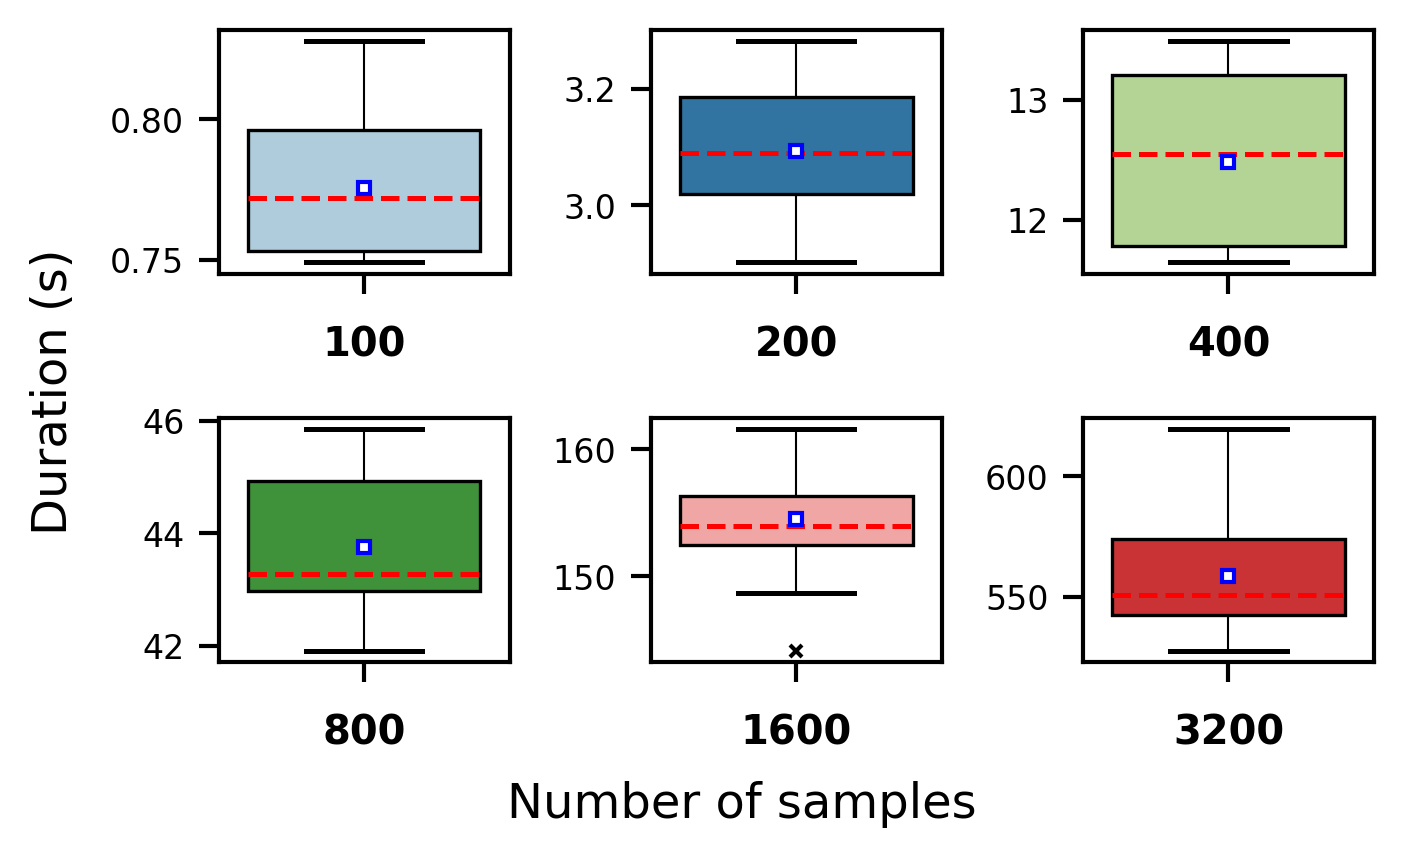

In [36]:
initBoxPlots(TC_RAA_DurationsDF, 'Number of samples', 'RAA', 'TC', '')

##### Remove Outliers

In [37]:
TC_RAA_Durations = []
for col in TC_RAA_DurationsDF.columns:
    q1 = TC_RAA_DurationsDF[col].quantile(0.25)
    q3 = TC_RAA_DurationsDF[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    durationNoFlier = TC_RAA_DurationsDF[col].loc[(TC_RAA_DurationsDF[col] >= q1 - 1.5*iqr) & 
                                                     (TC_RAA_DurationsDF[col] <= q3 + 1.5*iqr)]
    print(f"{col} samples(s)\t: Retained {len(durationNoFlier)} out of 30 samples")
    TC_RAA_Durations.append(durationNoFlier.mean())

100 samples(s)	: Retained 30 out of 30 samples
200 samples(s)	: Retained 30 out of 30 samples
400 samples(s)	: Retained 30 out of 30 samples
800 samples(s)	: Retained 30 out of 30 samples
1600 samples(s)	: Retained 29 out of 30 samples
3200 samples(s)	: Retained 30 out of 30 samples


##### Visualise Time Complexity Plots

In [38]:
TC_RAA_DF = pd.DataFrame({'numSample': TC_numSamples, 'duration': TC_RAA_Durations})
TC_RAA_DF.head()

numSample    duration
0        100    0.775667
1        200    3.093700
2        400   12.479467
3        800   43.747167
4       1600  154.845621

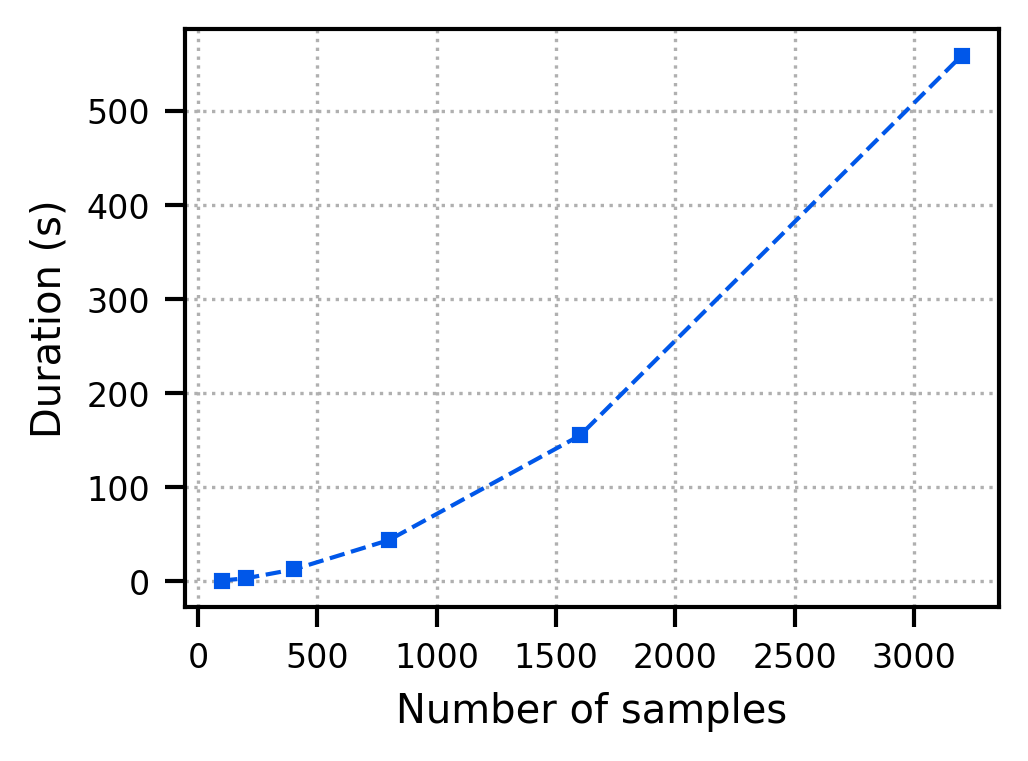

In [39]:
fig = plt.figure(figsize=figSize, dpi=dpi)
plt.plot(TC_RAA_DF['numSample'], TC_RAA_DF['duration'], 
         linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
plt.xlabel('Number of samples', fontsize='medium')
plt.ylabel('Duration (s)', fontsize='medium')
plt.tick_params(axis='both', labelsize='small')
plt.grid(linestyle='dotted')
plt.savefig('TC_RAA.png')

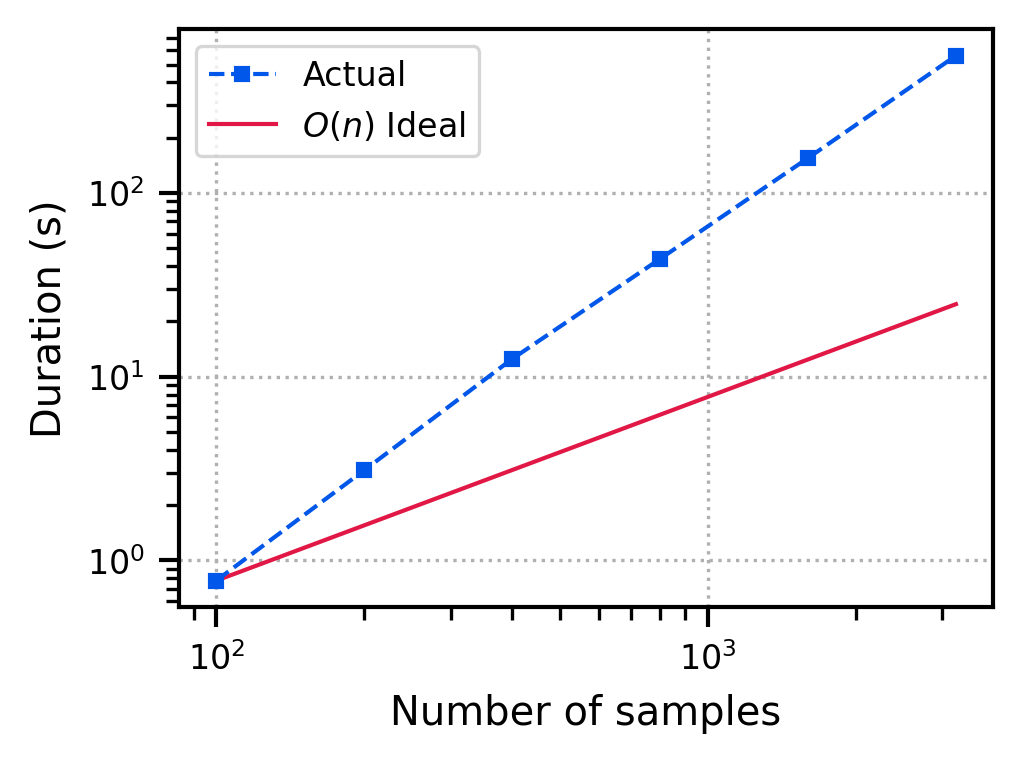

In [40]:
fig = plt.figure(figsize=figSize, dpi=dpi)
plt.plot(TC_RAA_DF['numSample'], TC_RAA_DF['duration'], 
         linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
plt.plot(TC_RAA_DF['numSample'], TC_RAA_DF['duration'][0] * (TC_RAA_DF['numSample'] / TC_RAA_DF['numSample'][0]), 
         linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
         color=hexCodes[0], zorder=2)
plt.loglog()
plt.xlabel('Number of samples', fontsize='medium')
plt.ylabel('Duration (s)', fontsize='medium')
plt.tick_params(axis='both', labelsize='small')
plt.grid(linestyle='dotted')
plt.legend(labels=('Actual', r'$O(n)$ Ideal'), fontsize='small')
plt.savefig('TC_RAA_loglog.png')

#### PIAA

##### Load Data into Dataframes

In [18]:
TC_PIAA_Durations = getAllDurations('runtimes/computationalComplexity', 'TC_PIAA_')
TC_PIAA_DurationsDF = pd.DataFrame(np.array(TC_PIAA_Durations).T, columns=TC_numSamples)
TC_PIAA_DurationsDF.head()

TC_EX_10
TC_EX_14
TC_EX_17
TC_EX_20
TC_EX_27
TC_EX_31
TC_EX_38
TC_EX_49
TC_EX_61
TC_EX_77
TC_EX_98
TC_EX_123


43      87      177     321     683     1055    1961     4189     8007   \
0  3.0839  3.2172  3.9249  4.1376  4.6429  6.2691  8.4466  15.7427  41.3705   
1  2.9248  3.0735  3.7808  4.0388  4.5946  6.3052  8.4785  15.5936  42.3517   
2  2.8078  3.1649  3.7606  4.0739  4.7250  6.2691  8.3515  15.6853  43.9182   
3  3.0193  3.3125  4.0052  4.1977  4.8063  6.2600  8.4473  15.7832  43.0820   
4  2.8914  3.3306  3.8553  4.1605  4.6659  6.2499  8.4309  15.7505  45.5026   

      16187     33573      66283  
0  114.1816  412.1617  1730.5496  
1  111.0604  398.2988  1748.9562  
2  110.1384  388.2153  1751.1370  
3  110.8998  396.8636  1739.4529  
4  110.8788  408.2686  1711.0565

##### Visualise via Box Plots

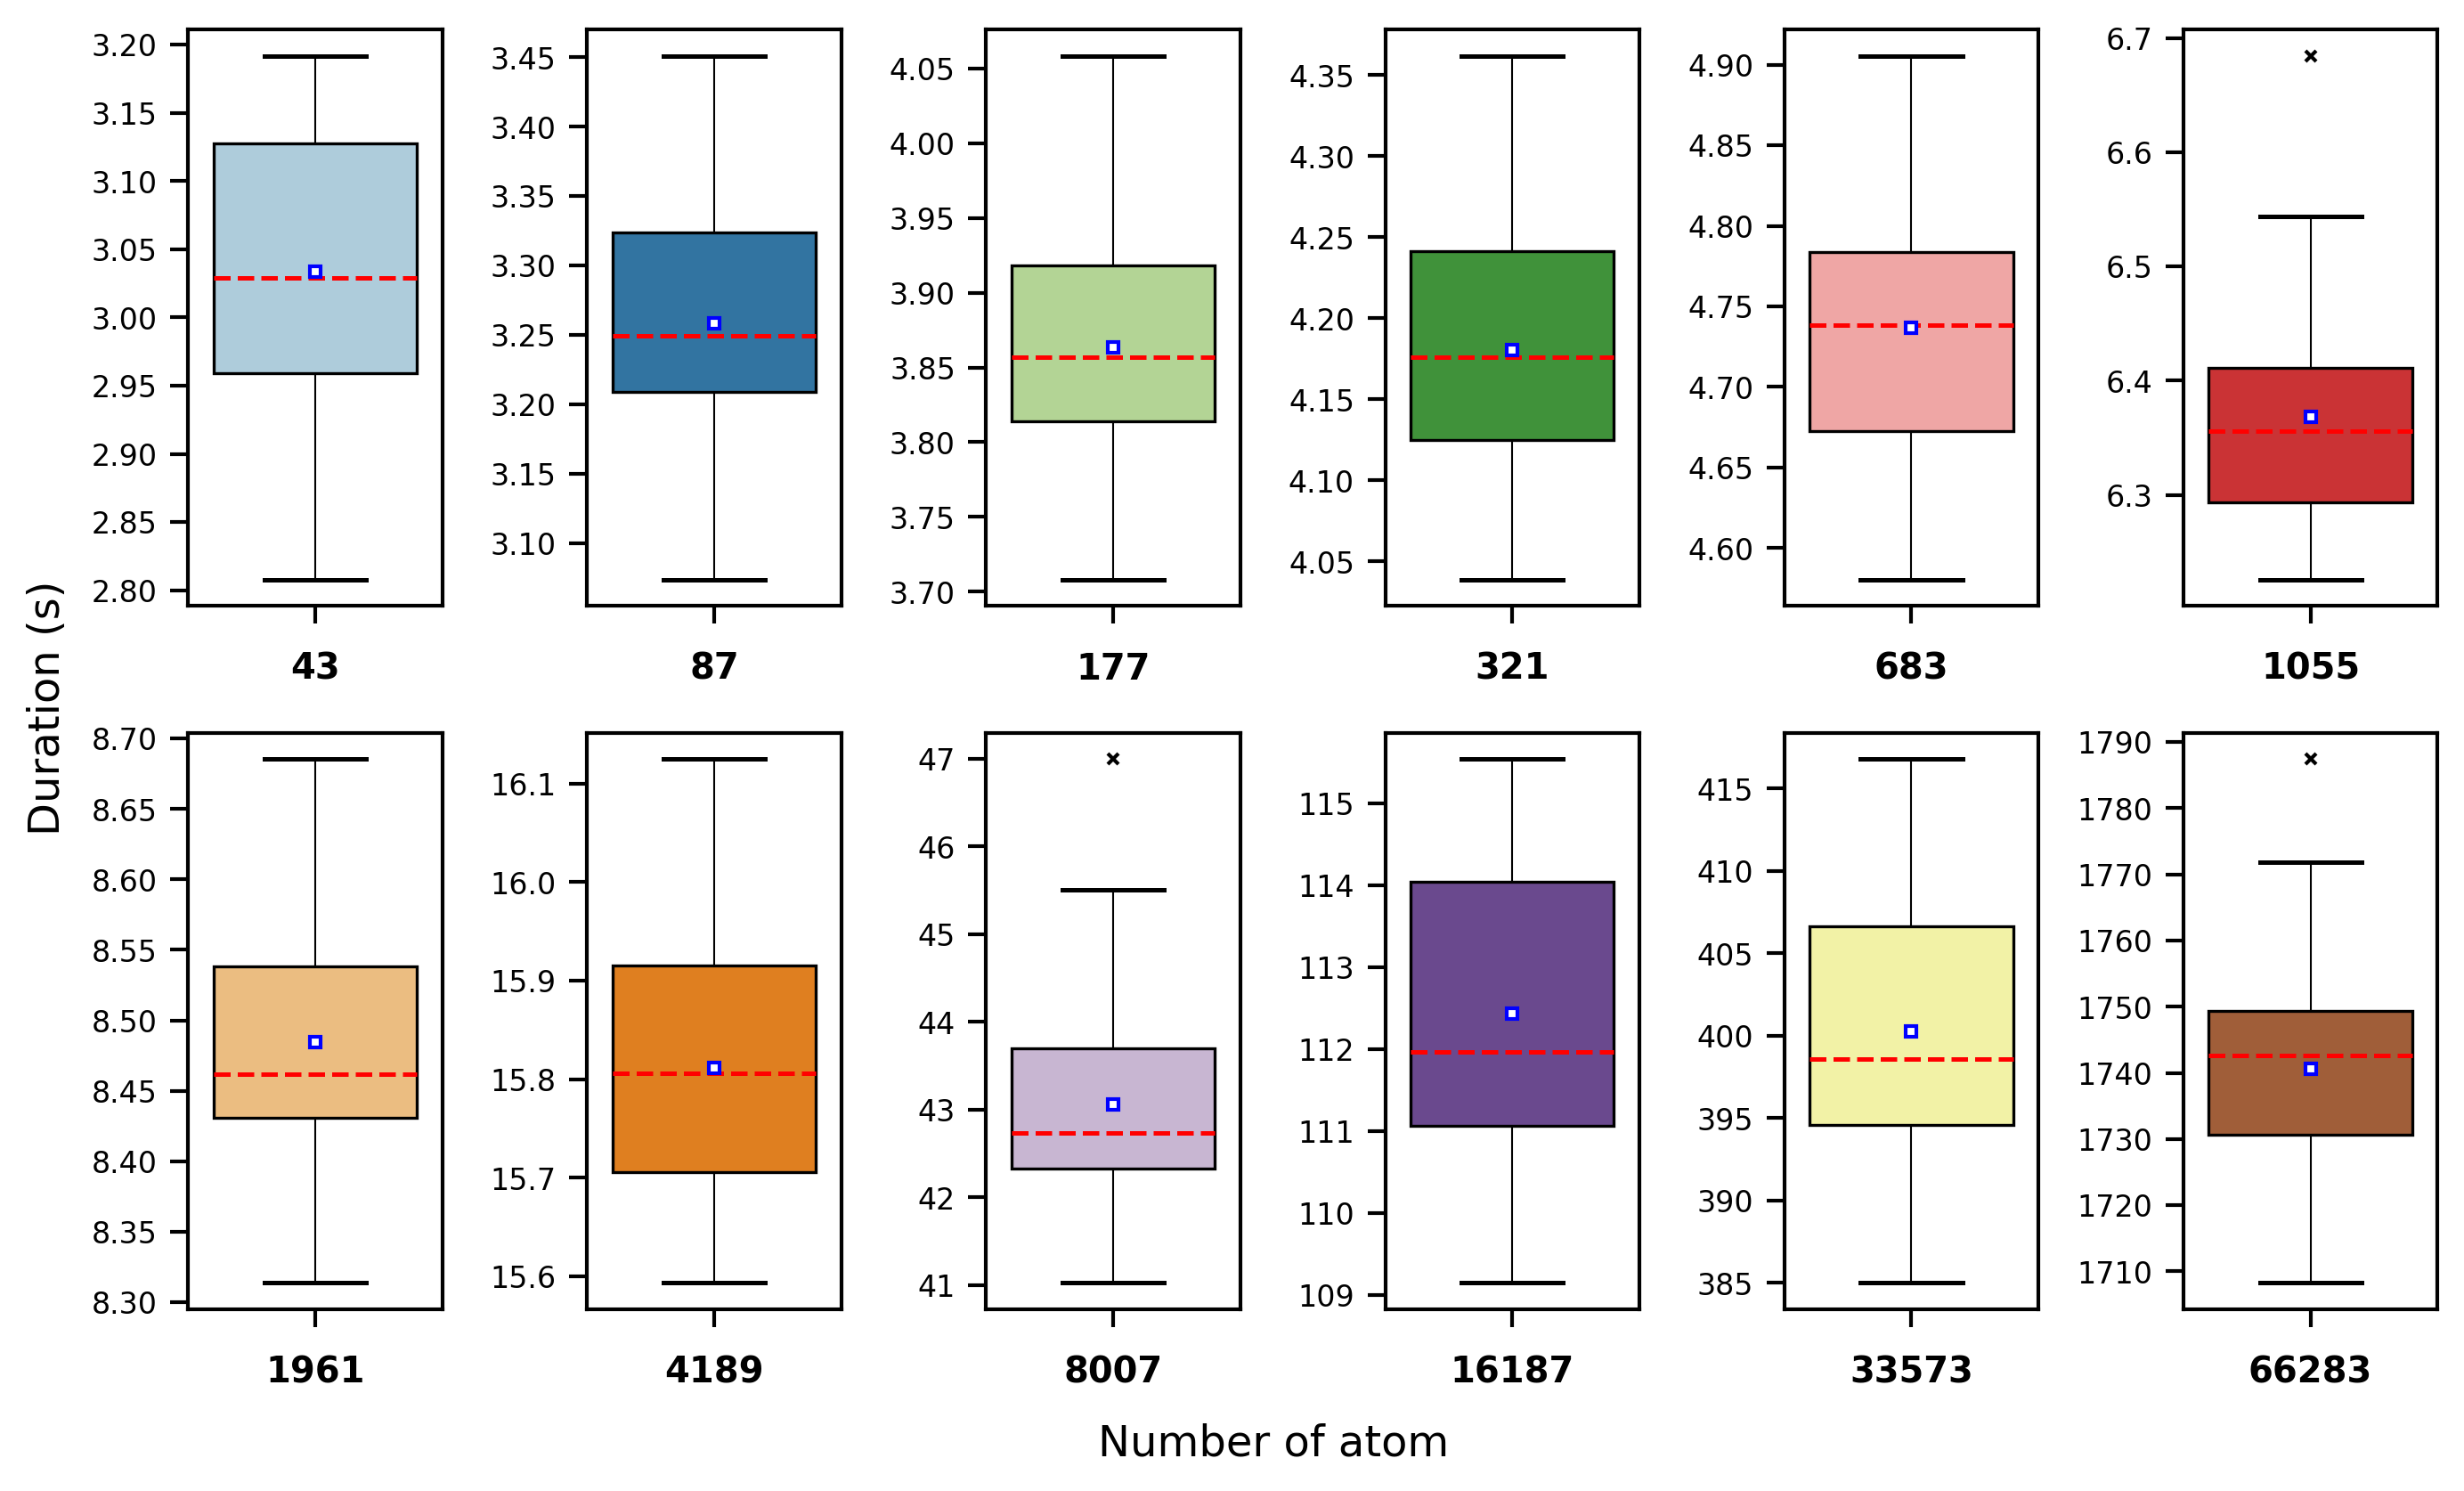

In [19]:
initBoxPlots(TC_PIAA_DurationsDF, 'Number of samples', 'PIAA', 'TC', '')

##### Remove Outliers

In [20]:
TC_PIAA_Durations = []
for col in TC_PIAA_DurationsDF.columns:
    q1 = TC_PIAA_DurationsDF[col].quantile(0.25)
    q3 = TC_PIAA_DurationsDF[col].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    durationNoFlier = TC_PIAA_DurationsDF[col].loc[(TC_PIAA_DurationsDF[col] >= q1 - 1.5*iqr) & 
                                                     (TC_PIAA_DurationsDF[col] <= q3 + 1.5*iqr)]
    print(f"{col} samples(s)\t: Retained {len(durationNoFlier)} out of 30 samples")
    TC_PIAA_DurationsDF.append(durationNoFlier.mean())

43 atoms(s)	: Retained 30 out of 30 samples
87 atoms(s)	: Retained 30 out of 30 samples
177 atoms(s)	: Retained 30 out of 30 samples
321 atoms(s)	: Retained 30 out of 30 samples
683 atoms(s)	: Retained 30 out of 30 samples
1055 atoms(s)	: Retained 29 out of 30 samples
1961 atoms(s)	: Retained 30 out of 30 samples
4189 atoms(s)	: Retained 30 out of 30 samples
8007 atoms(s)	: Retained 29 out of 30 samples
16187 atoms(s)	: Retained 30 out of 30 samples
33573 atoms(s)	: Retained 30 out of 30 samples
66283 atoms(s)	: Retained 29 out of 30 samples


##### Visualise Time Complexity Plots

In [21]:
TC_PIAA_DF = pd.DataFrame({'numSample': TC_numSamples, 'duration': TC_PIAA_Durations})
TC_PIAA_DF.head()

natom  nsatom  diameter  duration
0     43      30        10  3.033380
1     87      44        14  3.258407
2    177     108        17  3.863713
3    321     158        20  4.180393
4    683     254        27  4.736540

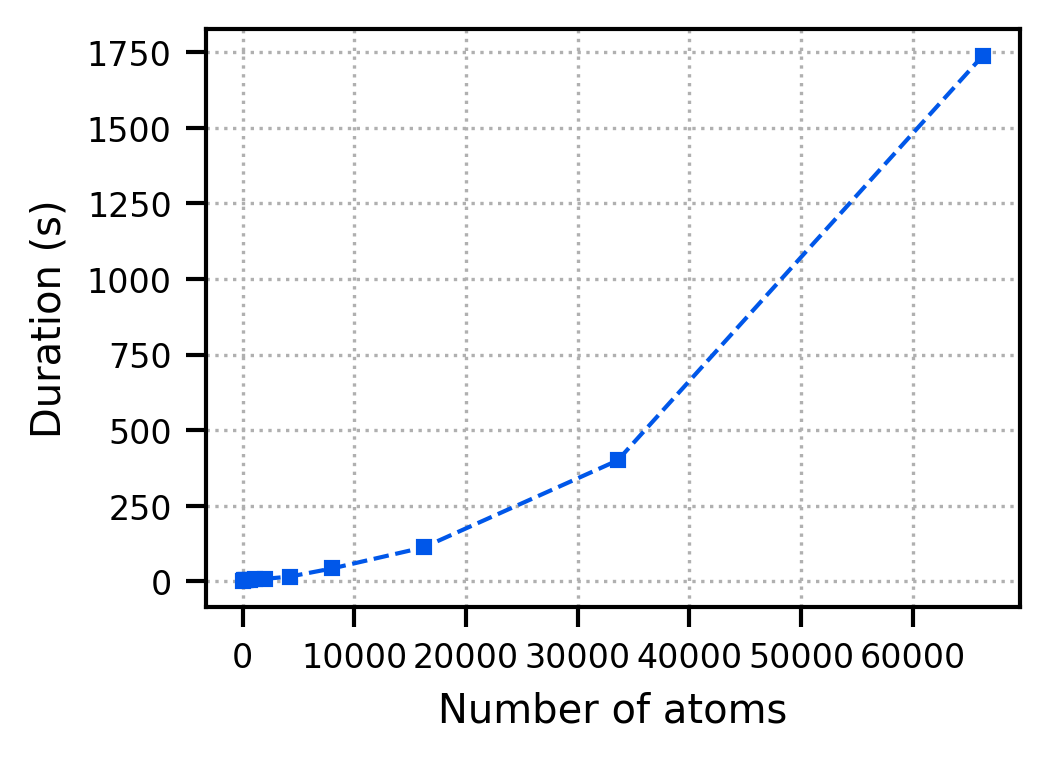

In [22]:
fig = plt.figure(figsize=figSize, dpi=dpi)
plt.plot(TC_PIAA_DF['numSample'], TC_PIAA_DF['duration'], 
         linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
plt.xlabel('Number of samples', fontsize='medium')
plt.ylabel('Duration (s)', fontsize='medium')
plt.tick_params(axis='both', labelsize='small')
plt.grid(linestyle='dotted')
plt.savefig('TC_PIAA.png')

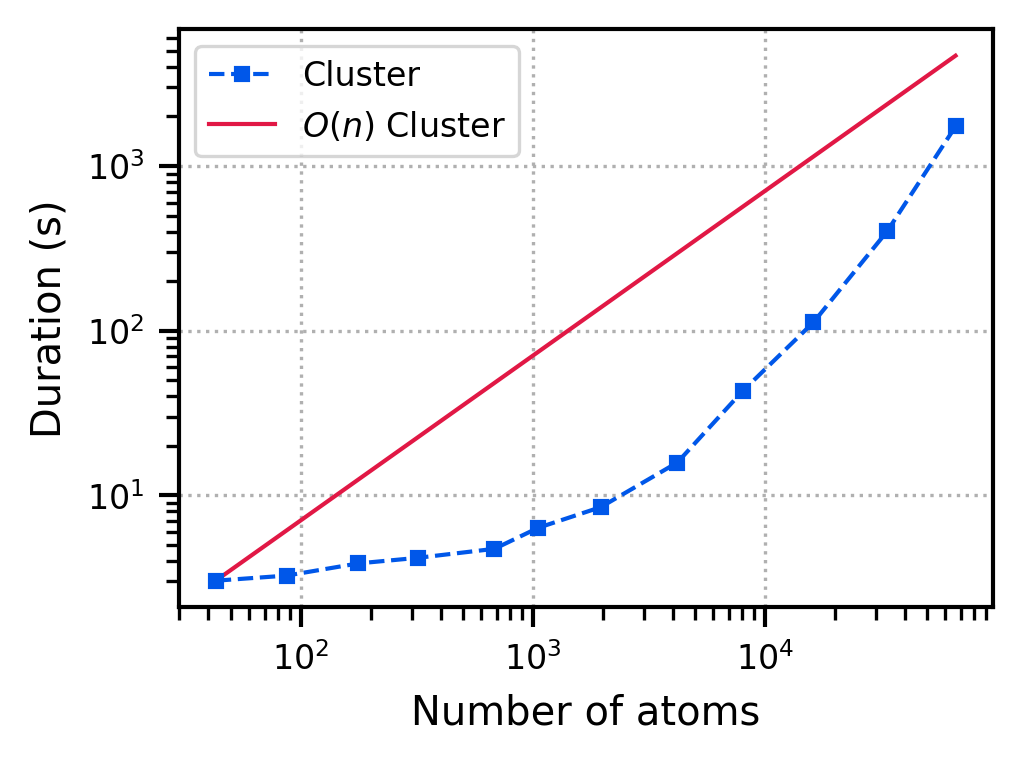

In [23]:
fig = plt.figure(figsize=figSize, dpi=dpi)
plt.plot(TC_PIAA_DF['numSample'], TC_PIAA_DF['duration'], 
         linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
plt.plot(TC_PIAA_DF['numSample'], TC_PIAA_DF['duration'][0] * (TC_PIAA_DF['natom'] / TC_PIAA_DF['natom'][0]), 
         linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
         color=hexCodes[0], zorder=2)
plt.loglog()
plt.xlabel('Number of samples', fontsize='medium')
plt.ylabel('Duration (s)', fontsize='medium')
plt.tick_params(axis='both', labelsize='small')
plt.grid(linestyle='dotted')
plt.legend(labels=('Actual', r'$O(n)$ Ideal'), fontsize='small')
plt.savefig('TC_PIAA_loglog.png')

#### Comparison Plots

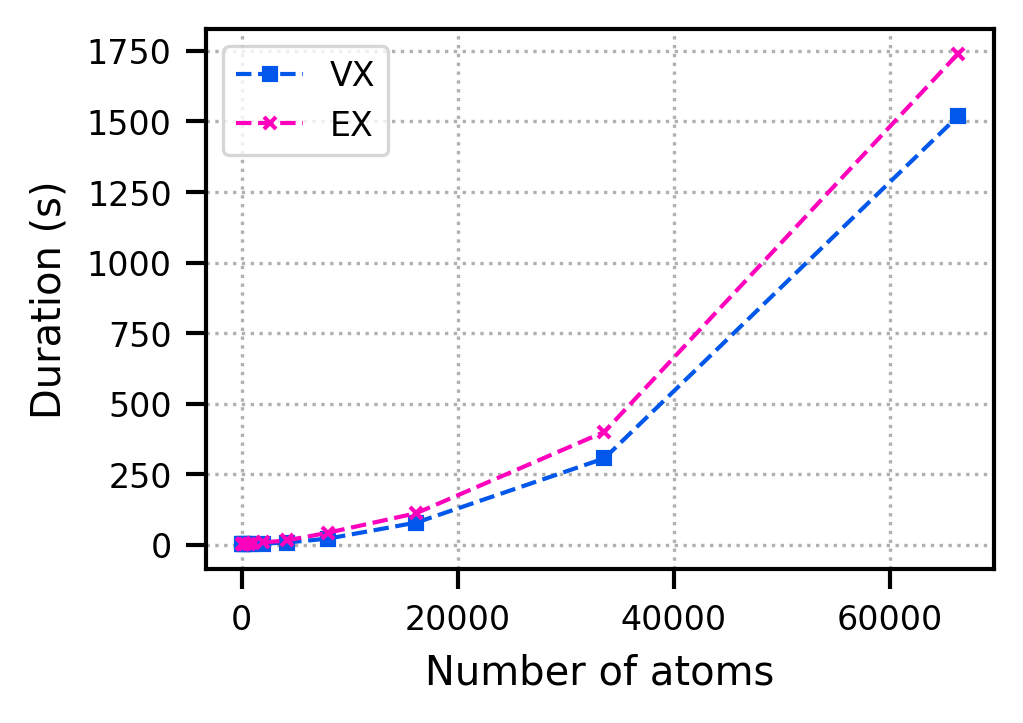

In [26]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_RAA_DF['numSample'], TC_RAA_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_PIAA_DF['numSample'], TC_PIAA_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.set_xlabel('Number of samples', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('RAA', 'PIAA'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_RAAPIAA.png')

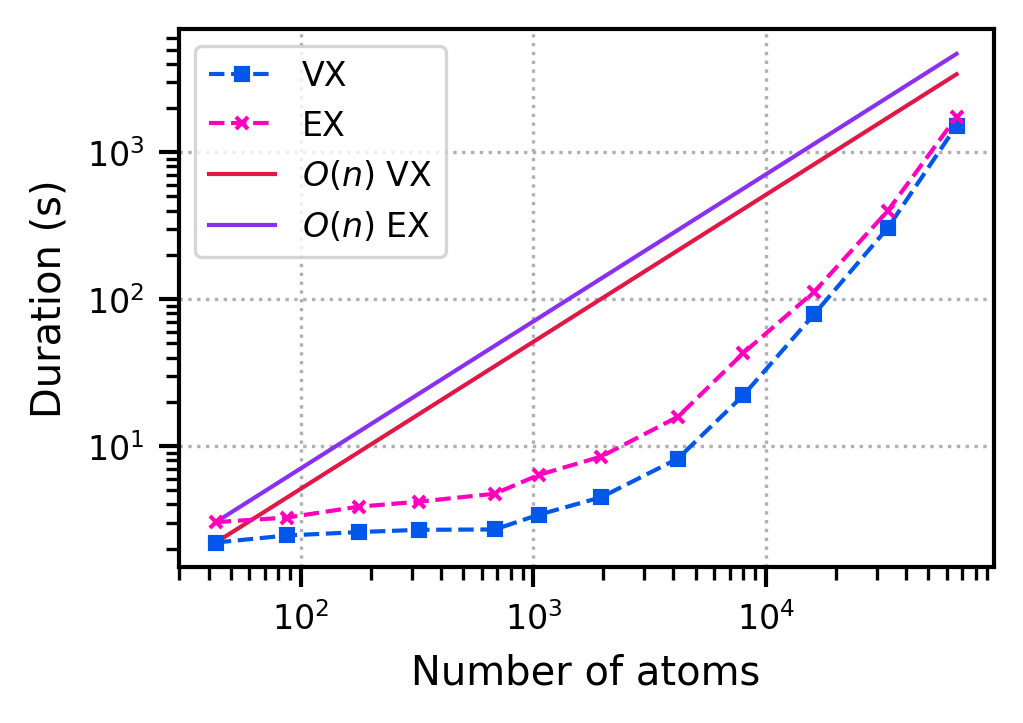

In [27]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(TC_RAA_DF['numSample'], TC_RAA_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='s', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(TC_PIAA_DF['numSample'], TC_PIAA_DF['duration'], 
        linewidth=lineWidth, linestyle='--', marker='x', markersize=markerSize, color=hexCodes[2], zorder=3)
ax.plot(TC_RAA_DF['numSample'], TC_RAA_DF['duration'][0] * (TC_RAA_DF['numSample'] / TC_RAA_DF['numSample'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[0], zorder=2)
ax.plot(TC_PIAA_DF['numSample'], TC_PIAA_DF['duration'][0] * (TC_PIAA_DF['numSample'] / TC_PIAA_DF['numSample'][0]), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, 
        color=hexCodes[3], zorder=2)
ax.loglog()
ax.set_xlabel('Number of samples', fontsize='medium')
ax.set_ylabel('Duration (s)', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('RAA', 'PIAA', r'$O(n)$ RAA', r'$O(n)$ PIAA'), fontsize='small')
plt.tight_layout()
plt.savefig('TC_RAAPIAA_loglog.png')

## Scalability Tests

Scalability, also referred to as parallelisation efficiency, is the ability to handle more work as the amount of resources grows. It is important for parallel computing to be efficient. Ideally, algorithms should have a linear speedup as the number of processors increases, but that is extremely difficult to be attained in real world applications, as it would imply 100% contribution of computational power from each processor.

When using high performance computing clusters, it is often worthwhile to measure the scaling of the algorithms used for resource planning. This is done via:

* strong scaling, which concerns the speedup for a fixed problem size with respect to the number of processors, and is governed by [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law); and
* weak scaling, which concerns the speedup for a scaled problem size with respect to the number of processors, and is governed by [Gustafson's law](https://en.wikipedia.org/wiki/Gustafson%27s_law). 

The results of strong and weak scaling tests can provide good indications for the best match between job size and the amount of resources that should be requested for a particular job. Note that scalability testing measures the ability of the algorithm to perform with varying problem sizes and number of processors. It DOES NOT test the general functionality or correctness of the algorithm.

### Technical Specifications

The scalability tests were run on the same machine [Gadi](https://nci.org.au/our-systems/hpc-systems), where the complexity tests where run on.

### Settings

The run times were obtained from 30 independent runs of the whole pipeline, using configurations/parameters expected for production runs.

### Strong Scaling

To calculate strong scaling speedup, the number of processors is increased while the problem size remains constant, which results in a reduced workload per processor.

The test case here is a data set with 6400 samples (the most time-consuming case covered in the time complexity analysis) and 1000 features.

The number of archetypes are fixed to be 10% of the number of samples, and the number of subsets are set to be the ratio of the number of samples to the number of archetypes (10).

In [1]:
SS_Ncpus = (48, 96, 192, 384, 768, 1536)
SS_Nnodes = (1, 2, 4, 8, 16, 32)

##### Outliers Removal

In [31]:
SS_VX_AllDurationFiles = [fname for fname in listdir('runtimes/strongScaling') if 'SS_VX_' in fname]
SS_VX_AllDurations = []
for fname in natsorted(SS_VX_AllDurationFiles):
    with open(f"runtimes/strongScaling/{fname}", 'r') as f:
        durations = []
        for line in f:
            if 'Run ' in line:
                durations.append(float(line.strip().split()[-2]))
    SS_VX_AllDurations.append(durations)

SS_VX_DurationsDF = pd.DataFrame(np.array(SS_VX_AllDurations).T, columns=SS_Ncpus) 
SS_VX_DurationsDF.head()

1         2         4         8         16        24        48  \
0  411.0372  380.9771  362.7527  362.5716  329.9859  331.8919  336.3240   
1  410.8568  391.0253  359.5118  366.4759  337.1682  335.6490  335.7460   
2  403.5821  393.4254  360.3983  375.7200  346.9441  342.7180  328.9400   
3  411.0103  399.0650  358.9036  364.9906  337.8440  336.7670  365.3184   
4  410.1773  393.8181  358.6358  362.9492  333.8061  334.5345  340.5540   

         96  
0  334.4611  
1  349.4397  
2  335.8623  
3  332.8262  
4  344.5258

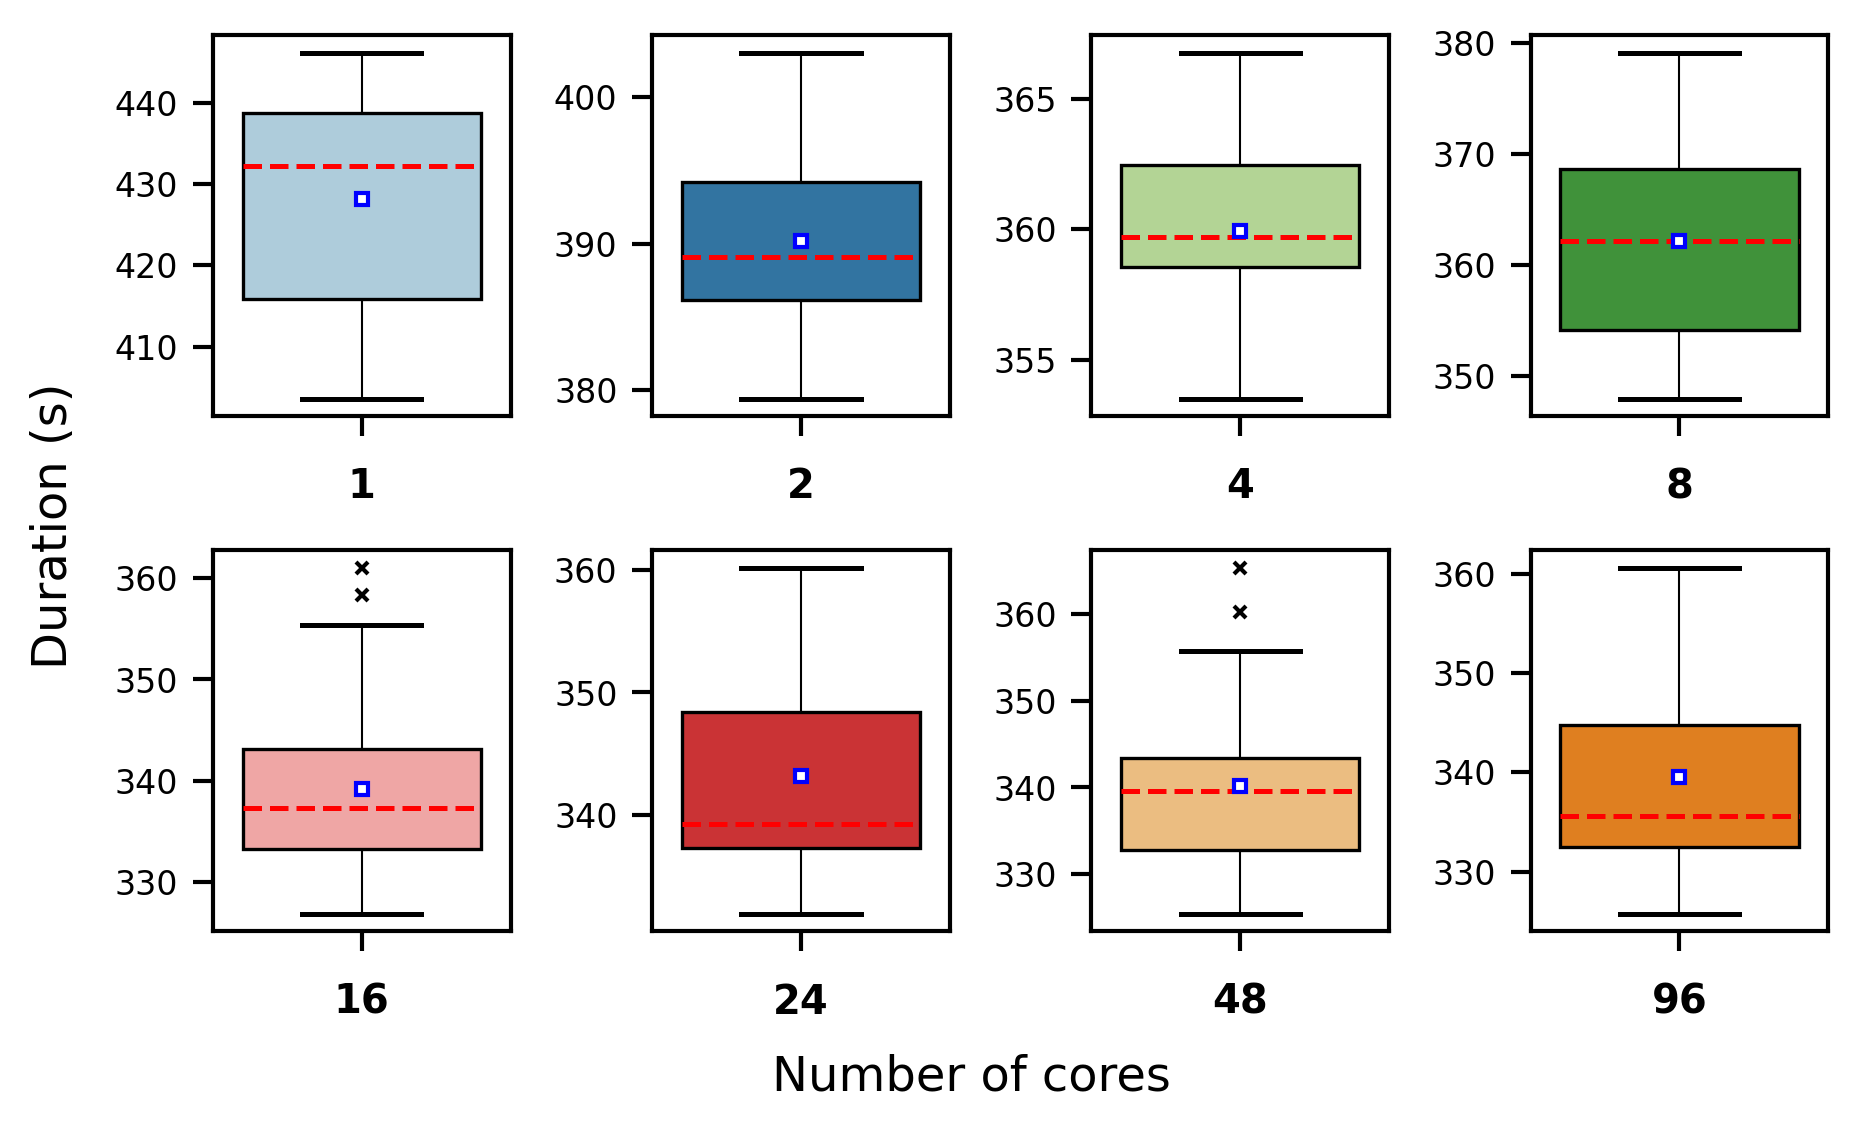

In [32]:
initBoxPlots(SS_VX_DurationsDF, 'Number of cores', 'VX', 'SS', '', '')

In [33]:
SS_VX_Durations = rmOutliers(SS_VX_DurationsDF, 'cpu')

1 cpu(s)	: Retained 30 out of 30 samples
2 cpu(s)	: Retained 30 out of 30 samples
4 cpu(s)	: Retained 30 out of 30 samples
8 cpu(s)	: Retained 30 out of 30 samples
16 cpu(s)	: Retained 28 out of 30 samples
24 cpu(s)	: Retained 30 out of 30 samples
48 cpu(s)	: Retained 28 out of 30 samples
96 cpu(s)	: Retained 30 out of 30 samples


##### Speedup Computation

We can then compute the strong scaling speedups and efficiencies:

In [34]:
SS_VX_DF = pd.DataFrame({'ncpu': SS_Ncpus, 'nnode': SS_Nnodes, 'duration': SS_VX_Durations})
SS_VX_DF['speedup'] = SS_VX_DF['duration'][0] / SS_VX_DF['duration']
SS_VX_DF['efficiency'] = (SS_VX_DF['duration'][0]*SS_VX_DF['ncpu'][0]) / (SS_VX_DF['duration']*SS_VX_DF['ncpu'])
SS_VX_DF.head()

ncpu  nnode    duration   speedup  efficiency
0     1      1  428.157937  1.000000    1.000000
1     2      1  390.194810  1.097293    0.548646
2     4      1  359.951337  1.189488    0.297372
3     8      1  362.152907  1.182257    0.147782
4    16      1  337.680182  1.267939    0.079246

##### Visualisation

And plot them:

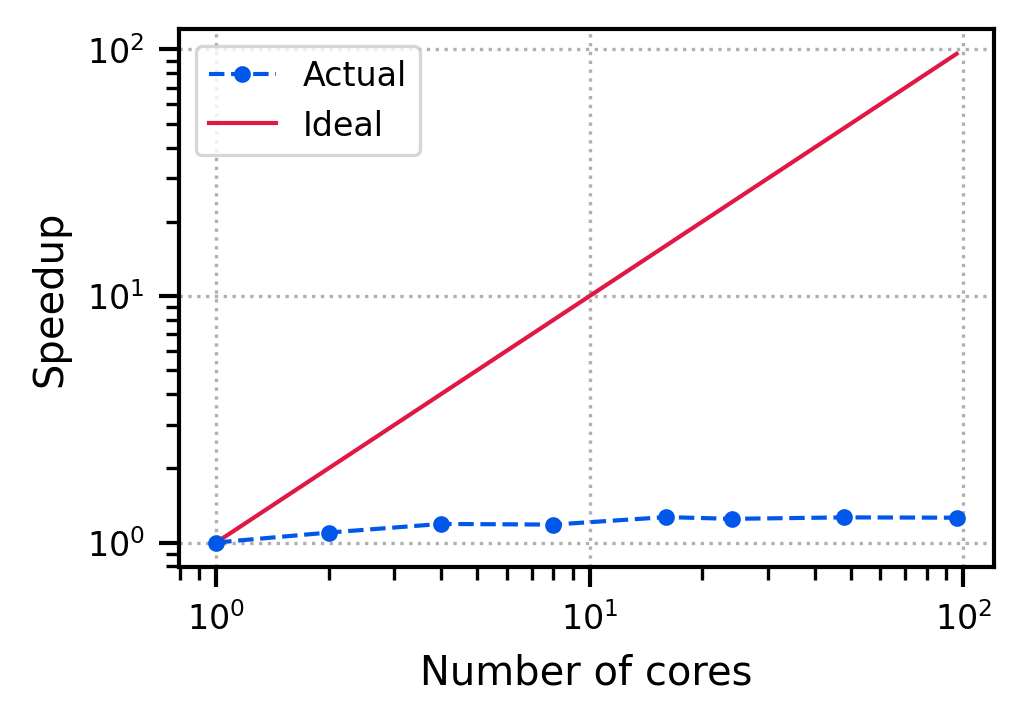

In [35]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
# SS_EX_DF.plot(x='ncpu', y='speedup', kind='line', ax=ax, figsize=figSize, title='Strong Scaling Voxelised Surface Speedup', grid=False, legend=True, style='o-', 
#               loglog=True, xlabel='Number of CPUs', ylabel='Speedup', fontsize=labelSize, colormap='Set1')
ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['speedup'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['ncpu'], 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)  # Amdahl's Law
ax.loglog()
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Speedup', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
# ax.set_title('Strong Scaling Voxelised Surface Speedups')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
plt.tight_layout()
plt.savefig('SS_VX_Speedups.png')

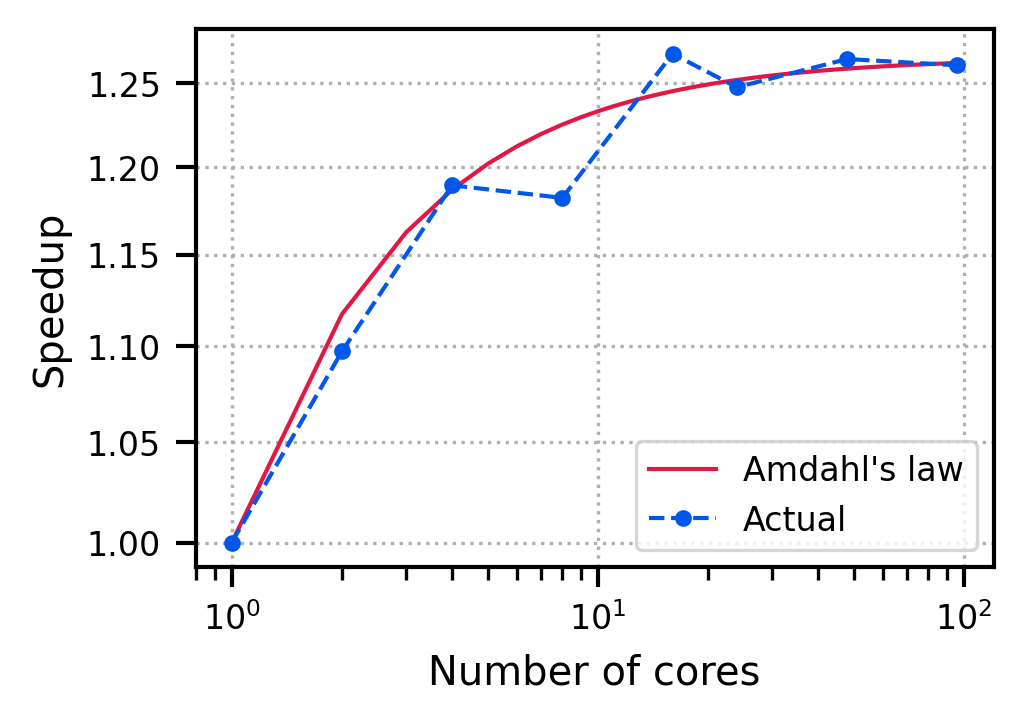

In [36]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)

# Amdahl's law
p = 0.21
s = np.array(range(1, SS_Ncpus[-1]+1))
amdahl = 1 / ((1-p) + p/s)
ax.plot(s, amdahl, 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)

ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['speedup'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.loglog()
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Speedup', fontsize='medium')
ax.set_yticks([1.00, 1.05, 1.10, 1.15, 1.20, 1.25])
ax.tick_params(axis='both', labelsize='small')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(linestyle='dotted')
ax.legend(labels=("Amdahl's law", 'Actual'), fontsize='small')
# ax.set_title('Strong Scaling Voxelised Surface Actual Speedup')
plt.tight_layout()
plt.savefig('SS_VX_Speedup.png')

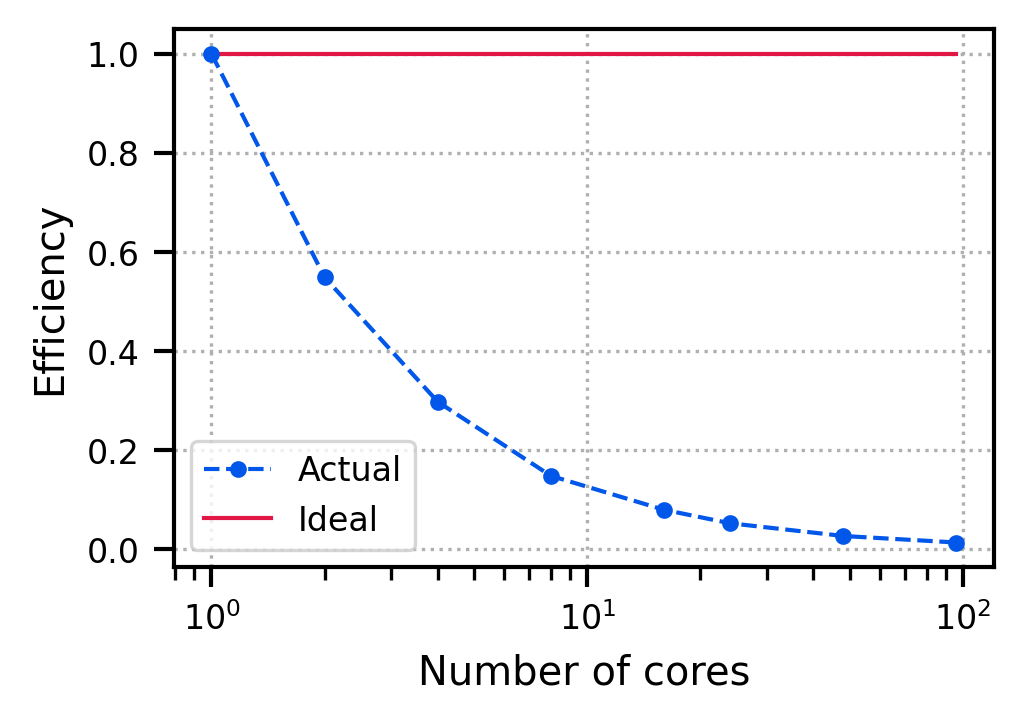

In [37]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(SS_VX_DF['ncpu'], SS_VX_DF['efficiency'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(SS_VX_DF['ncpu'], [1] * len(SS_VX_DF['ncpu']), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)
plt.xscale('log')
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Efficiency', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
# ax.set_title('Strong Scaling Voxelised Surface Efficiency')
plt.tight_layout()
plt.savefig('SS_VX_Efficiency.png')

### Weak Scaling

To calculate weak scaling parallelisation efficiency, the number of processors and the problem size are both increased, to maintain a constant workload per processor. 

Note that it was difficult to maintain a constant workload exactly in our case as the nanoparticles are generated based on diameters instead of number of atoms. The test cases were chosen based on the closest number of atoms to the ideal setup.

In [45]:
WS_Ncpus = (1, 2, 4, 8, 16, 24, 48, 96)
WS_Nnodes = (1, 1, 1, 1, 1, 1, 1, 2)
WS_NumAtomsIdeal = (43, 86, 172, 344, 688, 1032, 2064, 4128)
WS_NumAtoms = (43, 87, 177, 321, 683, 1055, 1961, 4189)
WS_Diameters = (10, 14, 17, 20, 27, 31, 38, 49)  # Angstroms
# for i in zip(WS_Ncpus, WS_Diameters): 
#     print(i)

In [46]:
WS_VX_AllDurations = getAllDurations('runtimes/weakScaling', 'WS_VX_')
WS_VX_DurationsDF = pd.DataFrame(np.array(WS_VX_AllDurations).T, columns=WS_Ncpus) 
WS_VX_DurationsDF.head()

WS_VX_1
WS_VX_2
WS_VX_4
WS_VX_8
WS_VX_16
WS_VX_24
WS_VX_48
WS_VX_96


1       2       4       8       16      24      48      96
0  2.1944  2.8814  2.6753  2.6991  2.7131  3.3573  4.1451  7.5584
1  2.1821  2.8610  2.7117  2.8082  2.6914  3.1802  3.8737  7.5316
2  2.2469  2.7631  2.7262  2.8951  2.7680  3.3348  4.0630  7.5766
3  2.2667  2.7647  2.7187  2.7921  2.7211  3.1751  3.9335  7.6830
4  2.1811  2.6569  2.6176  2.7760  2.7160  3.2599  3.8718  7.7785

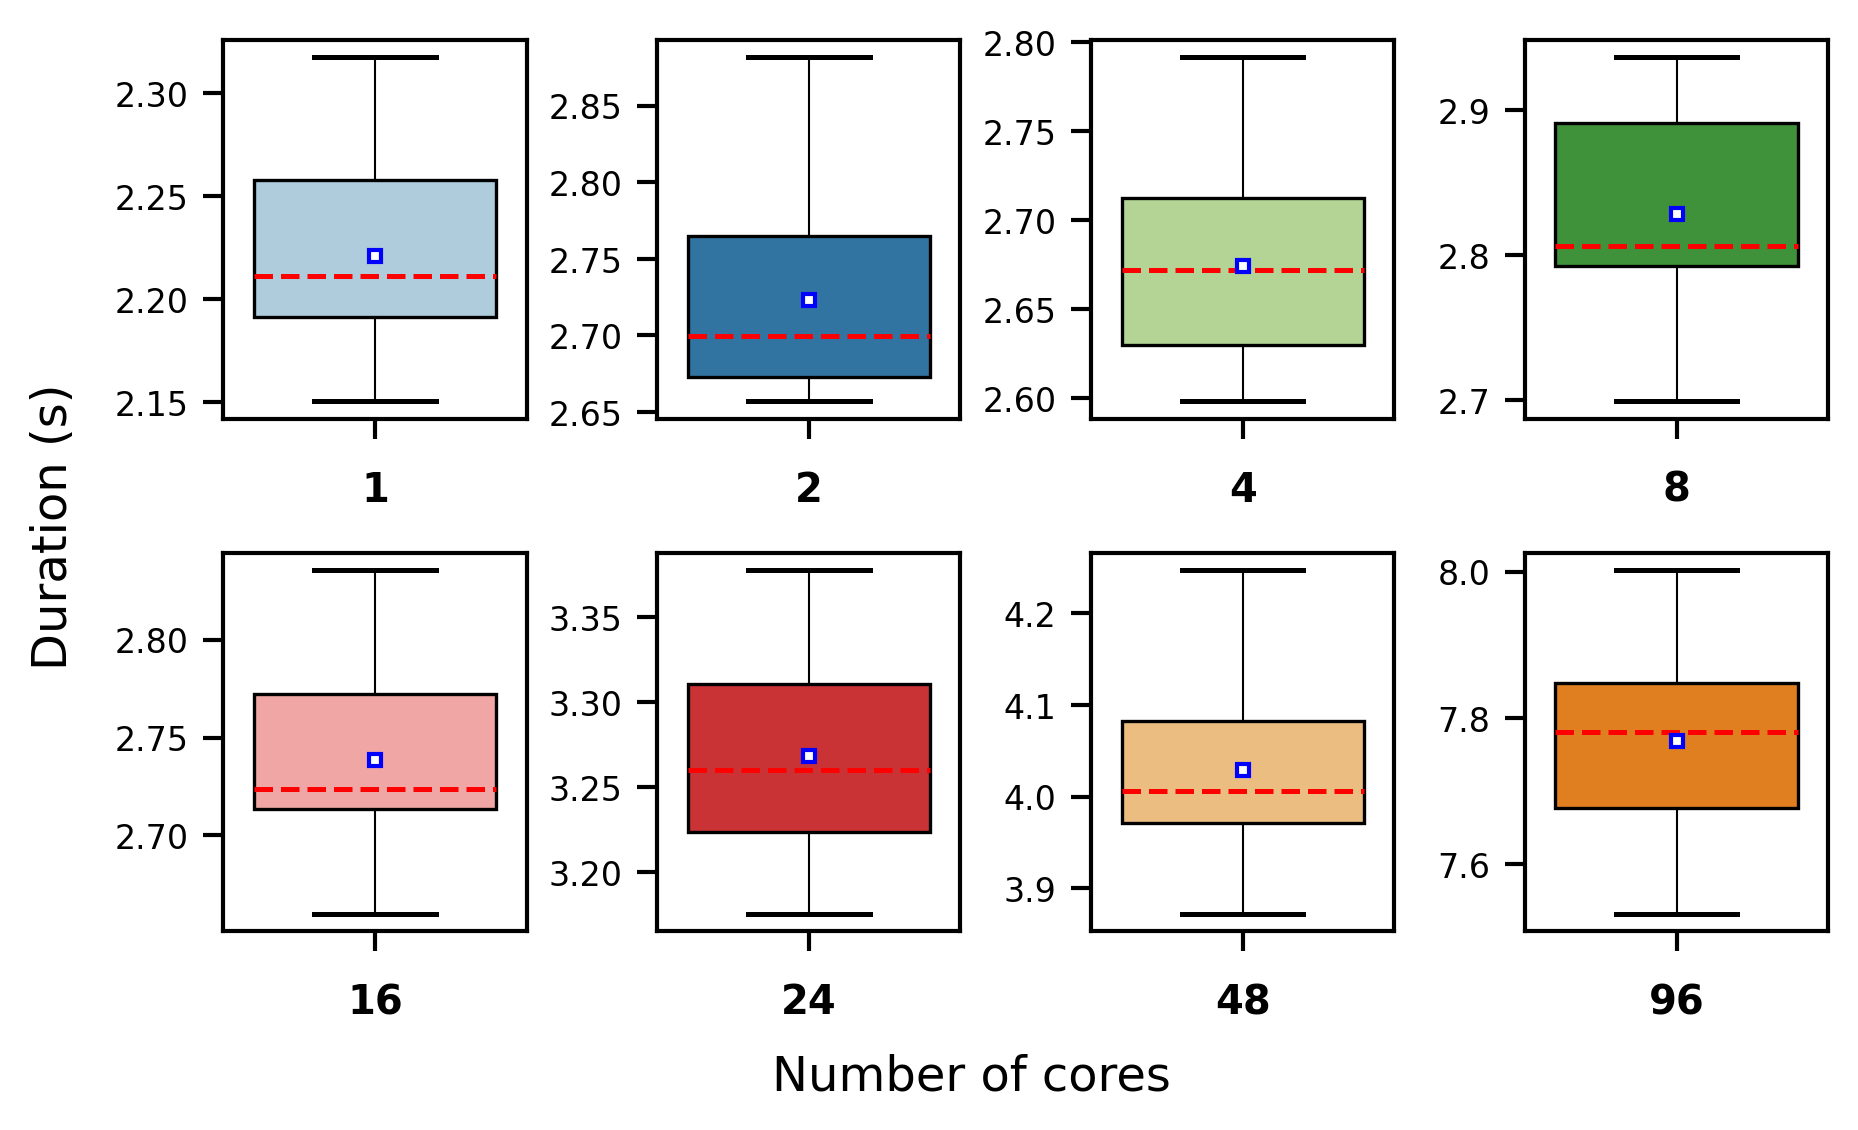

In [47]:
initBoxPlots(WS_VX_DurationsDF, 'Number of cores', 'VX', 'WS', '' ,'')

In [48]:
WS_VX_Durations = rmOutliers(WS_VX_DurationsDF, 'cpu')

1 cpu(s)	: Retained 30 out of 30 samples
2 cpu(s)	: Retained 30 out of 30 samples
4 cpu(s)	: Retained 30 out of 30 samples
8 cpu(s)	: Retained 30 out of 30 samples
16 cpu(s)	: Retained 30 out of 30 samples
24 cpu(s)	: Retained 30 out of 30 samples
48 cpu(s)	: Retained 30 out of 30 samples
96 cpu(s)	: Retained 30 out of 30 samples


We can then compute the weak scaling efficiencies and plot them:

In [49]:
WS_VX_DF = pd.DataFrame({'ncpu':WS_Ncpus, 'duration': WS_VX_Durations}, columns=['ncpu', 'duration'])
WS_VX_DF['efficiency'] = WS_VX_DF['duration'][0] / WS_VX_DF['duration']
WS_VX_DF.head()

ncpu  duration  efficiency
0     1  2.221050    1.000000
1     2  2.722783    0.815728
2     4  2.673820    0.830665
3     8  2.828557    0.785224
4    16  2.738643    0.811004

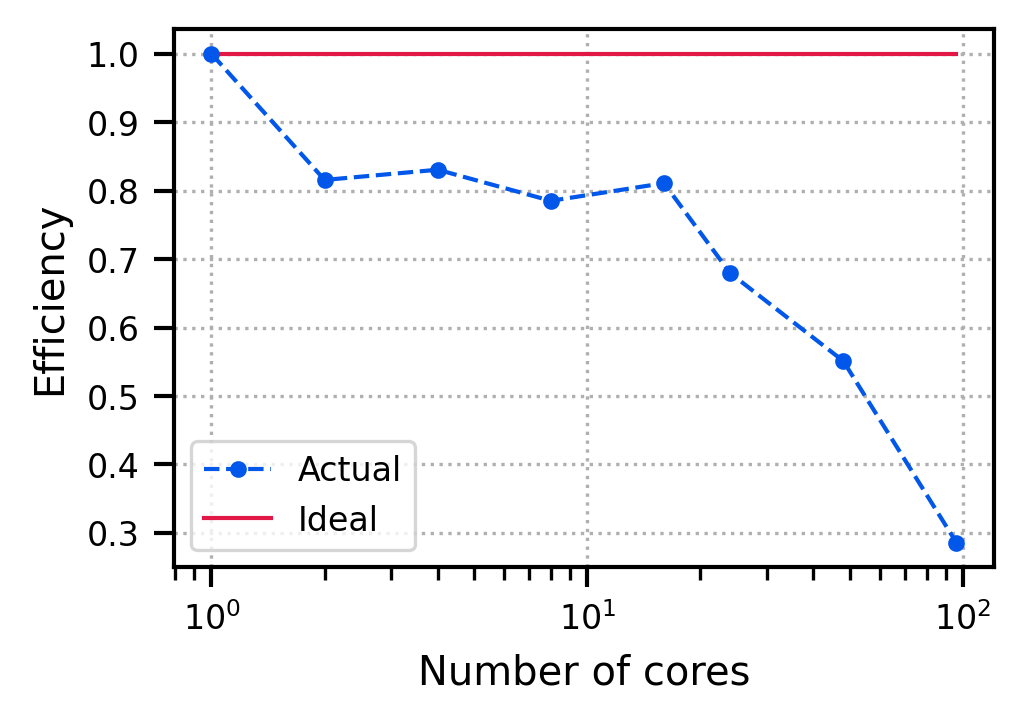

In [50]:
fig = plt.figure(figsize=figSize, dpi=dpi)
ax = fig.add_subplot(1, 1, 1)
ax.plot(WS_VX_DF['ncpu'], WS_VX_DF['efficiency'], 
        linewidth=lineWidth, linestyle='--', marker='o', markersize=markerSize, color=hexCodes[1], zorder=3)
ax.plot(WS_VX_DF['ncpu'], [1] * len(WS_VX_DF['ncpu']), 
        linewidth=lineWidth, linestyle='-', marker=None, markersize=markerSize, color=hexCodes[0], zorder=2)
plt.xscale('log')
ax.set_xlabel('Number of cores', fontsize='medium')
ax.set_ylabel('Efficiency', fontsize='medium')
ax.tick_params(axis='both', labelsize='small')
ax.grid(linestyle='dotted')
ax.legend(labels=('Actual', 'Ideal'), fontsize='small')
# ax.set_title('Weak Scaling Voxelised Surface Efficiency')
plt.tight_layout()
plt.savefig('WS_VX_Efficiency.png')

## Additional Runs

In [6]:
numArchetypes = 5

In [7]:
cAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=False, robust=ROBUST, only_archetypes=False,
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
cAA.fit(Xscaled)
print(f"Classical archetypal analysis execution time: {cAA.run_time:.3f} s")

RSS FISTA = 89437084
RSS FISTA = 72359437
RSS FISTA = 66442701
RSS AS = 61894631
RSS AS = 59614685
RSS AS = 58000809
RSS AS = 56317588
RSS AS = 54319957
RSS AS = 52671832
RSS AS = 51599220
RSS AS = 50914342
RSS AS = 50501120
RSS AS = 50274570
RSS AS = 50154844
RSS AS = 50089350
RSS AS = 50052805
RSS AS = 50032819
RSS AS = 50021660
RSS AS = 50015345
RSS AS = 50011793
RSS AS = 50009781
RSS AS = 50008652
RSS AS = 50008037
RSS AS = 50007706
RSS AS = 50007525
RSS AS = 50007425
RSS AS = 50007371
RSS AS = 50007343
RSS AS = 50007328
RSS AS = 50007319
RSS AS = 50007315
RSS AS = 50007312
RSS AS = 50007311
RSS AS = 50007310
RSS AS = 50007310
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
RSS AS = 50007309
Classical archetypal analysis executi

In [8]:
numSubset = 100
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")

RSS FISTA = 678427.94
RSS FISTA = 594706.73
RSS FISTA = 560594.26
RSS AS = 545766.6
RSS AS = 540927.95
RSS AS = 538169.72
RSS AS = 534888.22
RSS AS = 527289.71
RSS AS = 513370.04
RSS AS = 494135.76
RSS AS = 479305.72
RSS AS = 471930.15
RSS AS = 469525.77
RSS AS = 468886.73
RSS AS = 468676.41
RSS AS = 468609.27
RSS AS = 468588.87
RSS AS = 468582.81
RSS AS = 468581.01
RSS AS = 468580.47
RSS AS = 468580.29
RSS AS = 468580.24
RSS AS = 468580.22
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS AS = 468580.21
RSS 

In [9]:
numSubset = 1000
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")

RSS FISTA = 45607.919
RSS FISTA = 36192.914
RSS FISTA = 33868.668
RSS AS = 32696.511
RSS AS = 31062.894
RSS AS = 29804.787
RSS AS = 28958.267
RSS AS = 28530.677
RSS AS = 28348.709
RSS AS = 28270.596
RSS AS = 28239.825
RSS AS = 28227.755
RSS AS = 28222.639
RSS AS = 28220.373
RSS AS = 28219.315
RSS AS = 28218.793
RSS AS = 28218.519
RSS AS = 28218.362
RSS AS = 28218.268
RSS AS = 28218.211
RSS AS = 28218.175
RSS AS = 28218.153
RSS AS = 28218.139
RSS AS = 28218.13
RSS AS = 28218.124
RSS AS = 28218.12
RSS AS = 28218.118
RSS AS = 28218.117
RSS AS = 28218.116
RSS AS = 28218.115
RSS AS = 28218.115
RSS AS = 28218.115
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS AS = 28218.114
RSS A

In [7]:
numSubset = 10000
iAA = ArchetypalAnalysis(n_archetypes=numArchetypes, iterative=True, robust=ROBUST, only_archetypes=False, n_subsets=numSubset, shuffle=SHUFFLE, 
                         C=C, tolerance=TOLERANCE, computeXtX=COMPUTE_XTX, stepsFISTA=STEPS_FISTA, stepsAS=STEPS_AS, randominit=RANDOM_INIT, 
                         random_state=RANDOM_STATE, numThreads=NUM_JOBS)
iAA.fit(Xscaled)
print(f"Iterative archetypal analysis execution time: {iAA.run_time:.3f} s")

RSS FISTA = 2060.2417
RSS FISTA = 1610.525
RSS FISTA = 1504.5475
RSS AS = 1465.4978
RSS AS = 1456.4985
RSS AS = 1455.0708
RSS AS = 1454.8684
RSS AS = 1454.8391
RSS AS = 1454.8347
RSS AS = 1454.834
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS AS = 1454.8339
RSS A